Задание: классифицировать картини,построить модель 
Загрузка датасета с https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [ ]:
# Ksenia
# 25/3/2024
#v.01

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Пути к папкам с изображениями
data_dir = 'C:/Users/user/vs code/dz_photo'
data_val = os.path.join(data_dir, 'seg_test')
data_train = os.path.join(data_dir, 'seg_train')
data_pred = os.path.join(data_dir, 'seg_pred')

In [9]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [10]:
# Загрузка данных в DataFrame
def create_DF(path):
    label=[]
    data=[]
    folder=os.listdir(path)
    for fold in folder:
        fold_path=os.path.join(path,fold)
        files=os.listdir(fold_path)
        for file in files:
            file_path=os.path.join(fold_path,file)
            data.append(file_path)
            label.append(fold)
    LS = pd.Series(label, name= 'label')
    DS = pd.Series(data, name='file')
    DF=pd.concat([DS, LS], axis= 1)
    return DF

In [11]:
data_train=create_DF(data_train)
data_val=create_DF(data_val)

In [13]:
# Создание генераторов для данных обучения, валидации и тестирования
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)

# Создание генераторов изображений для обучения, валидации и тестирования
batch_size = 32
image_size = (150, 150)

# Использование метода flow_from_dataframe
train_set = train_data_gen.flow_from_dataframe(dataframe=data_train, 
                                               x_col='file', 
                                               y_col='label',
                                               target_size=image_size, 
                                               class_mode='categorical',
                                               shuffle=True, 
                                               batch_size=batch_size)

val_set = test_data_gen.flow_from_dataframe(dataframe=data_val, 
                                            x_col='file', 
                                            y_col='label',
                                            target_size=image_size, 
                                            class_mode='categorical',
                                            shuffle=True, 
                                            batch_size=batch_size)


Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [15]:
class PyDataset(tf.data.Dataset):
    def __init__(self, data, labels, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.labels = labels


## использвание relu:

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Определение колбэков
mode2_checkpoint_doc_init = ModelCheckpoint(
    'models/doc_init_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, min_lr=0.001, verbose=1)

In [20]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [37]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 254)            │     9,396,222 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,473,002 (108.62 MB)

 Trainable params: 9,491,000 (36.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,982,002 (72.41 MB)

In [21]:
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Обучение модели
history2 = model2.fit(train_set, epochs=10,
                    verbose=2,
                    validation_data=val_set,
                    
                    callbacks=[model_checkpoint_doc_init, early_stop, reduce_lr])

Epoch 1/10


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.72767, saving model to models/doc_init_model.keras
439/439 - 631s - 1s/step - accuracy: 0.6206 - loss: 0.9854 - val_accuracy: 0.7277 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy improved from 0.72767 to 0.74167, saving model to models/doc_init_model.keras
439/439 - 626s - 1s/step - accuracy: 0.7408 - loss: 0.7021 - val_accuracy: 0.7417 - val_loss: 0.7389 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy improved from 0.74167 to 0.81467, saving model to models/doc_init_model.keras
439/439 - 590s - 1s/step - accuracy: 0.7859 - loss: 0.5765 - val_accuracy: 0.8147 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy improved from 0.81467 to 0.82800, saving model to models/doc_init_model.keras
439/439 - 546s - 1s/step - accuracy: 0.8168 - loss: 0.5128 - val_accuracy: 0.8280 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy improved from 0.82800 to 0.84133

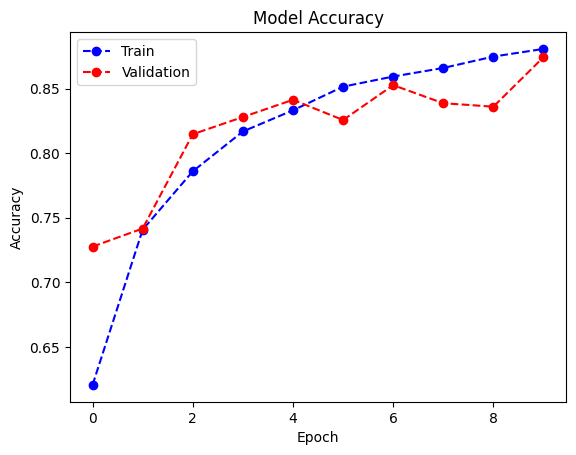

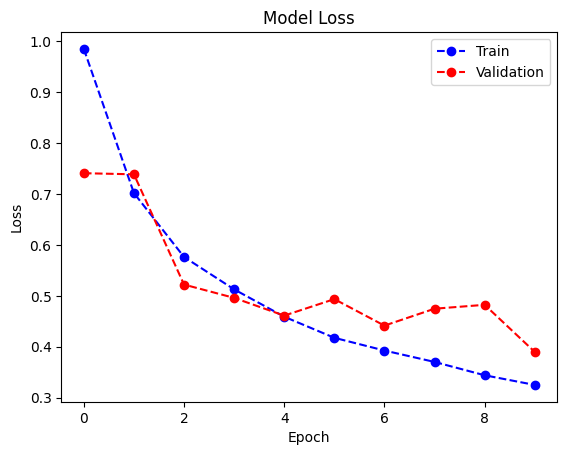

In [24]:
# визуализация метрик 
plt.plot(history2.history['accuracy'],'bo--', label='Train')
plt.plot(history2.history['val_accuracy'],'ro--', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history2.history['loss'],'bo--', label='Train')
plt.plot(history2.history['val_loss'],'ro--', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 283ms/step


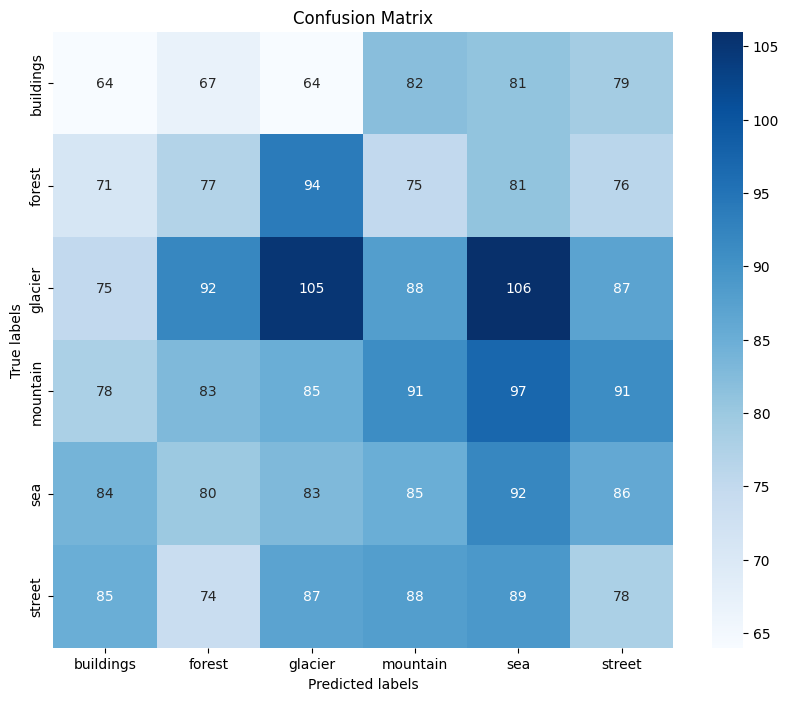

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Получение прогнозов модели для валидационного набора данных
predictions = model2.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)

# Получение фактических меток
true_classes = val_set.classes

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_set.class_indices.keys(), yticklabels=val_set.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import classification_report

#  отчет о классификации
report2 = classification_report(true_classes, predicted_classes, target_names=class_names)

print(report2)


              precision    recall  f1-score   support

    mountain       0.14      0.15      0.14       437
      street       0.16      0.16      0.16       474
     glacier       0.20      0.19      0.20       553
   buildings       0.18      0.17      0.18       525
         sea       0.17      0.18      0.17       510
      forest       0.16      0.16      0.16       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



In [30]:
# Оценка модели
test_loss, test_acc = model2.evaluate(val_set)
print('Точность на тестовом наборе данных:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.8597 - loss: 0.4389
Точность на тестовом наборе данных: 0.8743333220481873


In [35]:
# сохранение модели

model2.save('model2.keras')


## Вывод:
я пробовала усовершенствовать модель с разными гиперрараметрами, слоями и тд. Но требудется еще доработка. 
Мои метрики precision, recall и f1-score для всех классов низкие... Модель имеет проблемы с классификацией всех классов:(
Увеличение количества данных не под силу моему пк, а улучшить баланс классов(добавить веса) я еще попробую потом


